# 装到当前 Kernel（comp5328）
%pip install -U pip setuptools wheel
%pip install numpy==1.26.4 scipy scikit-learn matplotlib
# PyTorch
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install pandas

In [61]:
import sys, platform, numpy, torch
print("Python:", platform.python_version())
print("Interpreter:", sys.executable)
print("numpy:", numpy.__version__)
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())

Python: 3.10.18
Interpreter: c:\Users\Loki\.conda\envs\comp5328\python.exe
numpy: 1.26.4
torch: 2.8.0+cpu | cuda: False


In [62]:
import numpy as np
from pathlib import Path
from typing import Dict, Tuple, Literal, Optional
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import  random, time, csv, os
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
from __future__ import annotations

## Data Loading

In [64]:
def load_dataset_inline(
    name: Literal["FashionMNIST0.3", "FashionMNIST0.6", "CIFAR"],
    base_dir: str | Path = "datasets",
    reshape: Optional[Literal["flat", "hwc", "chw"]] = None,
    scale: bool = True,
) -> Dict[str, np.ndarray]:
    """
    读取 NPZ 数据并可选重塑/缩放。返回 dict: {"Xtr","Str","Xts","Yts"}。
    """
    base_dir = Path(base_dir)
    fname = {
        "FashionMNIST0.3": "FashionMNIST0.3.npz",
        "FashionMNIST0.6": "FashionMNIST0.6.npz",
        "CIFAR": "CIFAR.npz",
    }[name]
    path = base_dir / fname
    if not path.exists():
        raise FileNotFoundError(f"未找到数据文件: {path}")

    with np.load(path) as f:
        Xtr, Str, Xts, Yts = f["Xtr"], f["Str"], f["Xts"], f["Yts"]

    # ---- 缩放到 [0,1] ----
    if scale:
        if Xtr.dtype == np.uint8:
            Xtr = Xtr.astype(np.float32) / 255.0
        if Xts.dtype == np.uint8:
            Xts = Xts.astype(np.float32) / 255.0

    # ---- 重塑图像形状 ----
    if reshape is None or reshape == "flat":
        # 保持原样：FMNIST 为 (n,784)，CIFAR 为 (n,32,32,3)
        pass
    else:
        if name.startswith("FashionMNIST"):
            # 接受 (n,784) 或 (n,28,28[,(1)])
            if Xtr.ndim == 2 and Xtr.shape[1] == 784:
                Xtr = Xtr.reshape(-1, 28, 28, 1)
                Xts = Xts.reshape(-1, 28, 28, 1)
            elif Xtr.ndim == 3 and Xtr.shape[1:] == (28, 28):
                Xtr = Xtr[..., None]
                Xts = Xts[..., None]
            elif Xtr.ndim == 4 and Xtr.shape[1:3] == (28, 28):
                # 已经有通道维
                pass
            else:
                raise ValueError(f"FMNIST 形状异常: Xtr={Xtr.shape}")

            if reshape == "chw":
                # (N,H,W,C)->(N,C,H,W)
                Xtr = np.transpose(Xtr, (0, 3, 1, 2))
                Xts = np.transpose(Xts, (0, 3, 1, 2))

        elif name == "CIFAR":
            # 期望 (n,32,32,3)
            if not (Xtr.ndim == 4 and Xtr.shape[1:4] == (32, 32, 3)):
                raise ValueError(f"CIFAR 形状异常: Xtr={Xtr.shape}")
            if reshape == "chw":
                Xtr = np.transpose(Xtr, (0, 3, 1, 2))
                Xts = np.transpose(Xts, (0, 3, 1, 2))
        else:
            raise ValueError(f"未知数据集: {name}")

    return {"Xtr": Xtr, "Str": Str, "Xts": Xts, "Yts": Yts}


In [65]:
# 2) 分层切分（内嵌工具函数）
# =========================
def split_train_val_inline(
    X: np.ndarray,
    y: np.ndarray,
    val_ratio: float = 0.2,
    seed: Optional[int] = 0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    按标签 y 分层切分（不依赖 sklearn）。
    返回: X_tr, y_tr, X_val, y_val
    """
    if not (0 < val_ratio < 1):
        raise ValueError("val_ratio 必须在 (0,1) 内")
    rng = np.random.default_rng(seed)

    classes = np.unique(y)
    idx_tr, idx_val = [], []
    for c in classes:
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n_val = max(1, int(len(idx) * val_ratio))
        idx_val.append(idx[:n_val])
        idx_tr.append(idx[n_val:])
    idx_tr = np.concatenate(idx_tr); idx_tr.sort()
    idx_val = np.concatenate(idx_val); idx_val.sort()

    return X[idx_tr], y[idx_tr], X[idx_val], y[idx_val]

## Helper Function

In [66]:
# ====== 1) NumPy 数组 → Torch Dataset（内嵌）======
class NumpyImageDataset(Dataset):
    def __init__(self, X, y, to_chw=True, z_norm=None):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
        # 可选：ensure CHW
        if self.X.ndim == 4 and self.X.shape[1] not in (1,3) and self.X.shape[-1] in (1,3):
            # HWC -> CHW
            self.X = self.X.permute(0,3,1,2)
        # 可选：z-normalization
        if z_norm is not None:
            mean, std = z_norm
            mean = torch.as_tensor(mean, dtype=self.X.dtype).view(1,-1,1,1)
            std  = torch.as_tensor(std,  dtype=self.X.dtype).view(1,-1,1,1)
            self.X = (self.X - mean) / (std + 1e-8)

    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

In [67]:
# ====== 2) 极简 CNN（FMNIST 足够）======
class SmallCNN(nn.Module):
    def __init__(self, num_classes=3, in_ch=1):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),    nn.ReLU(), nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        return self.head(self.feat(x))

In [68]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=3, in_ch=1, img_size=28):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),    nn.ReLU(), nn.MaxPool2d(2),
        )
        # 动态推断 flatten 维度
        with torch.no_grad():
            dummy = torch.zeros(1, in_ch, img_size, img_size)
            n_flat = int(np.prod(self.feat(dummy).shape[1:]))

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, 128), nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.head(self.feat(x))

In [69]:
# ====== 3) 噪声鲁棒损失 ======
class ForwardCorrectCE(nn.Module):
    """
    前向修正：先 softmax 得到 p(y|x)，再右乘 T 得到 p(tilde_y|x)=p @ T，
    再用 noisy label 计算 CE。
    T 形状: (C, C), T[i,j] = P(tilde=j | clean=i)
    """
    def __init__(self, T: np.ndarray):
        super().__init__()
        T = torch.as_tensor(T, dtype=torch.float32)
        assert T.shape[0] == T.shape[1], "T must be square"
        # 数值稳健 & 常驻 GPU
        self.register_buffer("T", T / (T.sum(dim=1, keepdim=True) + 1e-12))

    def forward(self, logits, noisy_y):
        p = F.softmax(logits, dim=1)              # (B,C)
        p_tilde = torch.clamp(p @ self.T, 1e-12, 1.0)  # (B,C)
        # 选择噪声标签对应概率做 -log
        loss = -torch.log(p_tilde[torch.arange(p.shape[0]), noisy_y])
        return loss.mean()

class GCELoss(nn.Module):
    """
    Generalized Cross Entropy: L = (1 - p_y^q) / q,   q in (0,1]
    p_y = softmax(logits)[range, noisy_y]
    q→0 逼近 MAE；q=1 等于 CE。
    """
    def __init__(self, q=0.7):
        super().__init__()
        assert 0 < q <= 1.0
        self.q = q
    def forward(self, logits, noisy_y):
        p = F.softmax(logits, dim=1)
        p_y = torch.clamp(p[torch.arange(p.shape[0]), noisy_y], 1e-12, 1.0)
        return ((1.0 - p_y.pow(self.q)) / self.q).mean()


In [70]:
# ====== 4) 训练 ======
def train_one_epoch(model, loader, optim, loss_fn, device="cuda"):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        optim.zero_grad(); loss.backward(); optim.step()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1); correct += (pred==y).sum().item(); total += x.size(0)
    return total_loss/total, correct/total

In [71]:
# ====== 5)评估 ======
@torch.no_grad()
def evaluate_ce(model, loader, device="cuda"):
    """用标准 CE 的预测来评估（干净测试集用 Yts）。"""
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return correct/total

In [72]:
# ===== 已知转移矩阵（3×3）=====
T_03 = np.array([
    [0.7, 0.3, 0.0],
    [0.0, 0.7, 0.3],
    [0.3, 0.0, 0.7],
], dtype=np.float32)

T_06 = np.array([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4],
], dtype=np.float32)

def _check_T(T, num_classes):
    assert T.shape == (num_classes, num_classes), \
        f"T must be {num_classes}x{num_classes}, got {T.shape}"
    assert np.all(T >= -1e-8), "T has negative entries"
    rowsum = T.sum(axis=1)
    assert np.allclose(rowsum, 1.0, atol=1e-6), f"Row sums not 1: {rowsum}"

# 依据当前数据集选择 T，并做一致性检查
def get_transition_matrix(dataset_name, noisy_labels):
    num_classes = len(np.unique(noisy_labels))
    if dataset_name == "FashionMNIST0.3":
        T = T_03
    elif dataset_name == "FashionMNIST0.6":
        T = T_06
    else:
        raise ValueError("This getter is only for the two FMNIST datasets.")
    _check_T(T, num_classes)
    return T

In [73]:
def set_seed(seed=0):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Training

Example

### GCE

In [74]:
# 读取 & 切分
data = load_dataset_inline("FashionMNIST0.3", base_dir="datasets", reshape="chw", scale=True)
Xtr_tr, Str_tr, Xtr_val, Str_val = split_train_val_inline(data["Xtr"], data["Str"], 0.2, seed=0)
mean = Xtr_tr.mean(axis=(0,2,3)); std = Xtr_tr.std(axis=(0,2,3)) + 1e-6

from torch.utils.data import DataLoader
train_ds = NumpyImageDataset(Xtr_tr, Str_tr, z_norm=(mean, std))
val_ds   = NumpyImageDataset(Xtr_val, Str_val, z_norm=(mean, std))
test_ds  = NumpyImageDataset(data["Xts"], data["Yts"], z_norm=(mean, std))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256)
test_loader  = DataLoader(test_ds,  batch_size=256)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallCNN(num_classes=3, in_ch=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = GCELoss(q=0.7)

for ep in range(10):  # 先跑10个epoch试水
    tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, device)
    # 不建议用 noisy-val 做早停，这里只打印训练过程
    print(f"[GCE] ep {ep:02d} | loss {tr_loss:.4f} | train_acc {tr_acc:.3f}")

test_acc = evaluate_ce(model, test_loader, device)   # 干净测试集
print("GCE | Test acc:", test_acc)

[GCE] ep 00 | loss 0.4633 | train_acc 0.665
[GCE] ep 01 | loss 0.4349 | train_acc 0.689
[GCE] ep 02 | loss 0.4297 | train_acc 0.691
[GCE] ep 03 | loss 0.4234 | train_acc 0.694
[GCE] ep 04 | loss 0.4197 | train_acc 0.695
[GCE] ep 05 | loss 0.4165 | train_acc 0.696
[GCE] ep 06 | loss 0.4166 | train_acc 0.697
[GCE] ep 07 | loss 0.4111 | train_acc 0.699
[GCE] ep 08 | loss 0.4092 | train_acc 0.701
[GCE] ep 09 | loss 0.4028 | train_acc 0.703
GCE | Test acc: 0.9666666666666667


### Forward Loss Correction

In [75]:
# 0.3 或 0.6 二选一：
T = get_transition_matrix("FashionMNIST0.3", Str_tr)  # 或者 "FashionMNIST0.6"

set_seed(0)
model_fc = SmallCNN(num_classes=3, in_ch=1).to(device)
opt_fc = torch.optim.Adam(model_fc.parameters(), lr=1e-3)
loss_fn_fc = ForwardCorrectCE(T)

for ep in range(10):
    tr_loss, tr_acc = train_one_epoch(model_fc, train_loader, opt_fc, loss_fn_fc, device)
    print(f"[ForwardCE] ep {ep:02d} | loss {tr_loss:.4f} | train_acc {tr_acc:.3f}")

test_acc_fc = evaluate_ce(model_fc, test_loader, device)
print("ForwardCE | Test acc:", test_acc_fc)


[ForwardCE] ep 00 | loss 0.6843 | train_acc 0.669
[ForwardCE] ep 01 | loss 0.6416 | train_acc 0.690
[ForwardCE] ep 02 | loss 0.6309 | train_acc 0.693
[ForwardCE] ep 03 | loss 0.6240 | train_acc 0.695
[ForwardCE] ep 04 | loss 0.6197 | train_acc 0.696
[ForwardCE] ep 05 | loss 0.6196 | train_acc 0.696
[ForwardCE] ep 06 | loss 0.6167 | train_acc 0.698
[ForwardCE] ep 07 | loss 0.6172 | train_acc 0.696
[ForwardCE] ep 08 | loss 0.6129 | train_acc 0.700
[ForwardCE] ep 09 | loss 0.6121 | train_acc 0.700
ForwardCE | Test acc: 0.9876666666666667


### estimate transition matrix

In [76]:
def estimate_T_anchor(Xtr, Str,
                      num_classes=3, in_ch=3, img_size=32,   # ★ 新增 img_size
                      warmup_epochs=5, batch_size=128, lr=1e-3,
                      tau=0.9, topk=200, device=None, z_norm=None):
    """
    Anchor-points 估计：
      1) 用 CE 暖身训练一个小模型；
      2) 对每一类 i，挑选该类的高置信样本（argmax==i 且 maxprob>=tau；不足则取 top-k）；
      3) 以这些样本的 noisy 标签频率作为转移概率，得到 T_hat[i,*]。
    返回: 形状 (num_classes, num_classes) 的 \hat T 。
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # —— DataLoader（注意我们传入的是带噪标签 Str）——
    ds = NumpyImageDataset(Xtr, Str, z_norm=z_norm)   # 你已有的工具类：支持 CHW & z-norm
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # —— 小模型：必须传入 img_size，避免 3136/4096 不匹配 —— ★
    model = SmallCNN(num_classes=num_classes, in_ch=in_ch, img_size=img_size).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    ce    = nn.CrossEntropyLoss()

    # 1) 暖身训练（CE 足够）
    for _ in range(warmup_epochs):
        model.train()
        for x, y in dl:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = ce(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()

    # 2) 全量前向，拿到 posterior 概率
    model.eval()
    with torch.no_grad():
        X_all = torch.from_numpy(Xtr).float()
        # 若是 HWC 就转成 CHW；不过你上游 reshape="chw" 一般已经是 CHW，这里只是兜底
        if X_all.ndim == 4 and X_all.shape[1] not in (1, 3) and X_all.shape[-1] in (1, 3):
            X_all = X_all.permute(0, 3, 1, 2)
        if z_norm is not None:
            mean, std = z_norm
            m = torch.as_tensor(mean, dtype=X_all.dtype).view(1, -1, 1, 1)
            s = torch.as_tensor(std,  dtype=X_all.dtype).view(1, -1, 1, 1)
            X_all = (X_all - m) / (s + 1e-8)
        X_all = X_all.to(device)

        logits = model(X_all)
        prob   = F.softmax(logits, dim=1).cpu().numpy()   # (N, C)

    pred = prob.argmax(1)   # (N,)
    conf = prob.max(1)      # (N,)

    # 3) 逐类统计 noisy 标签频率，得到 T_hat
    T_hat = np.zeros((num_classes, num_classes), dtype=np.float32)
    Str = np.asarray(Str).reshape(-1).astype(np.int64)

    for i in range(num_classes):
        idx = np.where(pred == i)[0]
        if idx.size == 0:
            # 该类几乎没人预测到：退化为均匀或单位对角的保守估计
            T_hat[i] = np.full(num_classes, 1.0 / num_classes, dtype=np.float32)
            continue

        # 优先用高置信阈值 tau
        idx_high = idx[conf[idx] >= tau]
        if idx_high.size >= 1:
            use_idx = idx_high
        else:
            # 兜底：按该类 posterior 排序，取 top-k
            take = min(topk, idx.size)
            top_idx = idx[np.argsort(prob[idx, i])[-take:]]
            use_idx = top_idx

        counts = np.bincount(Str[use_idx], minlength=num_classes).astype(np.float32)
        if counts.sum() == 0:
            counts = np.full(num_classes, 1.0 / num_classes, dtype=np.float32)
        T_hat[i] = counts / counts.sum()

    return T_hat

## Repeated Experiment

In [77]:
def run_once(dataset_name: str,
             method: str,                 # "gce" / "forward" / "forward_est"
             seed: int = 0,
             epochs: int = 10,
             batch_size: int = 128,
             lr: float = 1e-3,
             # 可选超参
             q: float = 0.7,
             tau: float = 0.9,
             topk: int = 200,
             warmup_epochs: int = 5,
             est_batch_size: int | None = None,
             est_lr: float | None = None,
             verbose: bool = False) -> Dict[str, Any]:

    set_seed(seed)

    # 1) 数据
    data = load_dataset_inline(dataset_name, base_dir="datasets", reshape="chw", scale=True)
    Xtr_tr, Str_tr, Xtr_val, Str_val = split_train_val_inline(data["Xtr"], data["Str"], 0.2, seed=seed)
    mean = Xtr_tr.mean(axis=(0, 2, 3));  std = Xtr_tr.std(axis=(0, 2, 3)) + 1e-6

    # 2) 通道与尺寸
    is_fashion = dataset_name.startswith("Fashion")
    in_ch    = 1 if is_fashion else 3
    img_size = 28 if is_fashion else 32          # ★ 关键信息
    num_classes = 3

    train_loader = DataLoader(NumpyImageDataset(Xtr_tr, Str_tr, z_norm=(mean, std)),
                              batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(NumpyImageDataset(data["Xts"], data["Yts"], z_norm=(mean, std)),
                              batch_size=256)

    # 3) 模型与优化器
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model  = SmallCNN(num_classes=num_classes, in_ch=in_ch, img_size=img_size).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=lr)

    # 4) 方法选择
    if method == "gce":
        loss_fn = GCELoss(q=q)

    elif method == "forward":
        if not is_fashion:
            raise ValueError("`forward` 需要已知 T，仅适用于 FashionMNIST；CIFAR 请用 `forward_est`。")
        T = get_transition_matrix(dataset_name, Str_tr)
        loss_fn = ForwardCorrectCE(T)

    elif method == "forward_est":
        # ★ 把 img_size 传进去
        T_hat = estimate_T_anchor(
            Xtr_tr, Str_tr,
            num_classes=num_classes, in_ch=in_ch, img_size=img_size,
            warmup_epochs=warmup_epochs,
            batch_size=est_batch_size or batch_size,
            lr=est_lr or lr,
            tau=tau, topk=topk,
            device=device, z_norm=(mean, std)
        )
        if verbose:
            print("Estimated T:\n", np.array2string(T_hat, precision=3))
        loss_fn = ForwardCorrectCE(T_hat)

    else:
        raise ValueError("method must be 'gce', 'forward', or 'forward_est'.")

    # 5) 训练
    for _ in range(epochs):
        _loss, _acc = train_one_epoch(model, train_loader, opt, loss_fn, device)

    # 6) 干净测试集评测
    test_acc = float(evaluate_ce(model, test_loader, device))

    # 7) 返回记录
    out: Dict[str, Any] = {
        "dataset": dataset_name, "method": method, "seed": seed,
        "epochs": epochs, "batch_size": batch_size, "lr": lr,
        "test_acc": test_acc
    }
    if method == "gce":
        out["q"] = q
    if method == "forward_est":
        out["tau"] = tau; out["topk"] = topk; out["warmup_epochs"] = warmup_epochs
    return out


In [78]:
def run_experiments(
    datasets=("FashionMNIST0.3", "FashionMNIST0.6"),
    methods=("gce", "forward"),            # 需要时加 "forward_est"
    seeds=range(10),
    epochs=10, batch_size=128, lr=1e-3,
    out_csv=None                           # 想保存就给个路径，如 "results.csv"
) -> pd.DataFrame:
    """
    批量跑实验 → 返回 DataFrame（也可选写入 CSV）。
    依赖：run_once(ds, meth, ...) -> dict（包含 test_acc 等字段）
    """
    rows = []

    # 若要写 CSV，只写常用的扁平字段（不写 T_hat 这类复杂对象）
    csv_fields = ["dataset","method","seed","epochs","batch_size","lr","test_acc"]
    writer = None
    csv_fh = None
    if out_csv:
        os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
        write_header = not os.path.exists(out_csv)
        csv_fh = open(out_csv, "a", newline="")
        writer = csv.DictWriter(csv_fh, fieldnames=csv_fields)
        if write_header:
            writer.writeheader()

    try:
        for ds in datasets:
            for meth in methods:
                accs = []
                for s in seeds:
                    res = run_once(ds, meth, seed=s, epochs=epochs, batch_size=batch_size, lr=lr)

                    # run_once 返回 dict：直接用；补齐缺失字段
                    row = dict(res)
                    row["test_acc"] = float(row["test_acc"])
                    row.setdefault("dataset", ds)
                    row.setdefault("method",  meth)
                    row.setdefault("seed",    s)
                    row.setdefault("epochs",  epochs)
                    row.setdefault("batch_size", batch_size)
                    row.setdefault("lr", lr)

                    rows.append(row)
                    accs.append(row["test_acc"])

                    if writer:
                        writer.writerow({k: row[k] for k in csv_fields})

                accs = np.asarray(accs, dtype=float)
                print(f"{ds} | {meth} | epochs={epochs} | "
                      f"mean±std = {accs.mean():.4f} ± {accs.std(ddof=1):.4f} (n={len(accs)})")
    finally:
        if csv_fh:
            csv_fh.close()

    return pd.DataFrame(rows)

In [79]:
def summarize_df(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby(["dataset","method"])["test_acc"]
    return g.agg(mean="mean", std="std", n="count").reset_index()

In [80]:
# 跑 FMNIST 两组，gce + forward
df = run_experiments(seeds=range(10), epochs=10, batch_size=128, lr=1e-3,
                     out_csv="results.csv")  # 不想存可传 None
display(df.head())
display(summarize_df(df))

FashionMNIST0.3 | gce | epochs=10 | mean±std = 0.9663 ± 0.0175 (n=10)
FashionMNIST0.3 | forward | epochs=10 | mean±std = 0.9886 ± 0.0018 (n=10)
FashionMNIST0.6 | gce | epochs=10 | mean±std = 0.6703 ± 0.0948 (n=10)
FashionMNIST0.6 | forward | epochs=10 | mean±std = 0.8589 ± 0.0493 (n=10)


,dataset,method,seed,epochs,batch_size,lr,test_acc,q
0,FashionMNIST0.3,gce,0,10,128,0.001,0.982333,0.7
1,FashionMNIST0.3,gce,1,10,128,0.001,0.956667,0.7
2,FashionMNIST0.3,gce,2,10,128,0.001,0.982667,0.7
3,FashionMNIST0.3,gce,3,10,128,0.001,0.941333,0.7
4,FashionMNIST0.3,gce,4,10,128,0.001,0.970000,0.7


,dataset,method,mean,std,n
0,FashionMNIST0.3,forward,0.988600,0.001769,10
1,FashionMNIST0.3,gce,0.966333,0.017493,10
2,FashionMNIST0.6,forward,0.858867,0.049272,10
3,FashionMNIST0.6,gce,0.670267,0.094769,10


In [81]:
# 2) CIFAR：gce + forward_est（估计 T）
df_cf = run_experiments(
    datasets=("CIFAR",),
    methods=("gce","forward_est"),
    seeds=range(10), epochs=10, batch_size=128, lr=1e-3,
    out_csv="results_cifar.csv"
)


CIFAR | gce | epochs=10 | mean±std = 0.4572 ± 0.0277 (n=10)
CIFAR | forward_est | epochs=10 | mean±std = 0.4734 ± 0.0374 (n=10)


In [82]:
# 合并 & 汇总
df_all = pd.concat([df, df_cf], ignore_index=True)
display(summarize_df(df_all))

,dataset,method,mean,std,n
0,CIFAR,forward_est,0.473433,0.037424,10
1,CIFAR,gce,0.457200,0.027720,10
2,FashionMNIST0.3,forward,0.988600,0.001769,10
3,FashionMNIST0.3,gce,0.966333,0.017493,10
4,FashionMNIST0.6,forward,0.858867,0.049272,10
5,FashionMNIST0.6,gce,0.670267,0.094769,10


## Visualization

In [83]:
def plot_errorbars_per_dataset(df_all, save_dir=None):
    sum_df = summarize_df(df_all)
    datasets = sum_df["dataset"].unique()
    for ds in datasets:
        sub = sum_df[sum_df["dataset"] == ds]
        x = np.arange(len(sub))
        plt.figure(figsize=(6,4))
        plt.errorbar(x, sub["mean"].values, yerr=sub["std"].values, fmt='o', capsize=4)
        plt.xticks(x, sub["method"].values)
        plt.ylabel("Test accuracy")
        plt.title(f"{ds} — mean ± std over seeds (n={int(sub['n'].iloc[0])})")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/{ds}_errorbars.png", dpi=200)
        plt.show()

In [84]:
def plot_box_per_dataset(df_all, save_dir=None):
    datasets = df_all["dataset"].unique()
    for ds in datasets:
        sub = df_all[df_all["dataset"] == ds]
        # 透视成：列=method，行=seed，值=test_acc
        pivot = sub.pivot_table(values="test_acc", index="seed", columns="method")
        plt.figure(figsize=(max(6, pivot.shape[1]*0.8), 4))
        pivot.plot(kind="box")
        plt.ylabel("Test accuracy")
        plt.title(f"{ds} — distribution over seeds")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/{ds}_box.png", dpi=200)
        plt.show()


In [85]:
def plot_errorbars_grouped_color(df_all, save_path=None):
    sum_df   = summarize_df(df_all)
    datasets = sum_df["dataset"].unique().tolist()
    methods  = sum_df["method"].unique().tolist()

    base_colors = plt.get_cmap("tab10").colors
    color_map = {m: base_colors[i % len(base_colors)] for i, m in enumerate(sorted(methods))}
    nice_name = {"gce": "GCE", "forward": "Forward", "forward_est": "FwdEst"}

    x_base  = np.arange(len(datasets))
    width   = 0.22
    offsets = np.linspace(-width, width, num=len(methods))

    fig_w = max(6.5, 2.2 * len(datasets))
    fig_h = 4.0
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    handles, labels = [], []

    for off, m in zip(offsets, methods):
        y, yerr = [], []
        for d in datasets:
            row = sum_df[(sum_df["dataset"]==d) & (sum_df["method"]==m)]
            if len(row)==0:
                y.append(np.nan); yerr.append(0.0)
            else:
                y.append(float(row["mean"].iloc[0]))
                yerr.append(float(row["std"].iloc[0]))
        x = x_base + off
        c = color_map[m]
        eb = ax.errorbar(x, y, yerr=yerr, fmt='o', color=c, ecolor=c,
                         capsize=5, markersize=6, linewidth=1,
                         label=nice_name.get(m, m))
        handles.append(eb); labels.append(nice_name.get(m, m))

    ds_short = {"FashionMNIST0.3":"FMNIST0.3", "FashionMNIST0.6":"FMNIST0.6", "CIFAR":"CIFAR"}
    ax.set_xticks(x_base)
    ax.set_xticklabels([ds_short.get(d, d) for d in datasets], fontsize=11)

    ax.set_ylim(0, 1.02)
    ax.set_ylabel("Test accuracy")
    ax.set_title("All datasets — mean ± std over seeds")
    ax.grid(axis='y', linestyle='--', alpha=0.35)

    # —— 把图例放到图外右侧 —— #
    fig.subplots_adjust(right=0.78, bottom=0.18, top=0.88)   # 右边留白
    ax.legend(handles, labels, title="Method",
              loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
    plt.show()

,dataset,method,mean,std,n
0,CIFAR,forward_est,0.473433,0.037424,10
1,CIFAR,gce,0.457200,0.027720,10
2,FashionMNIST0.3,forward,0.988600,0.001769,10
3,FashionMNIST0.3,gce,0.966333,0.017493,10
4,FashionMNIST0.6,forward,0.858867,0.049272,10
5,FashionMNIST0.6,gce,0.670267,0.094769,10


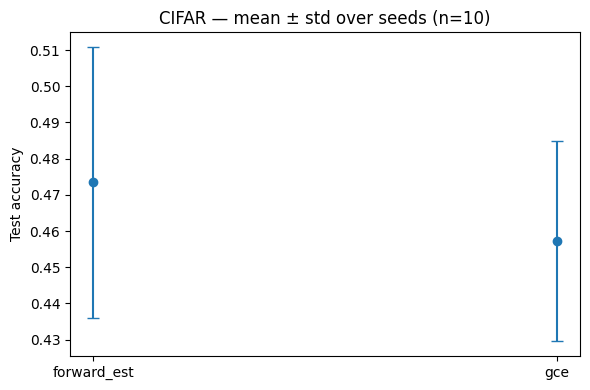

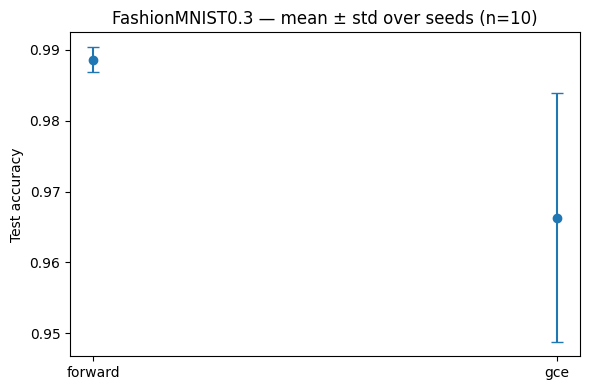

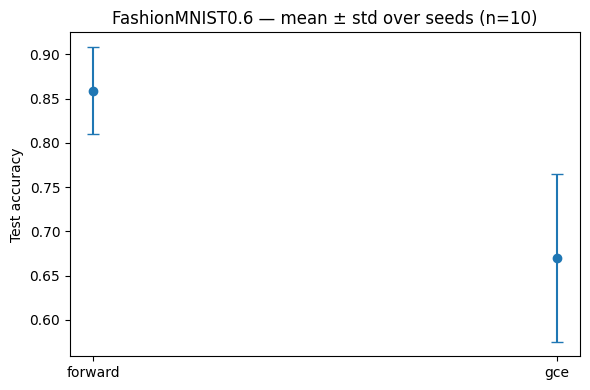

<Figure size 600x400 with 0 Axes>

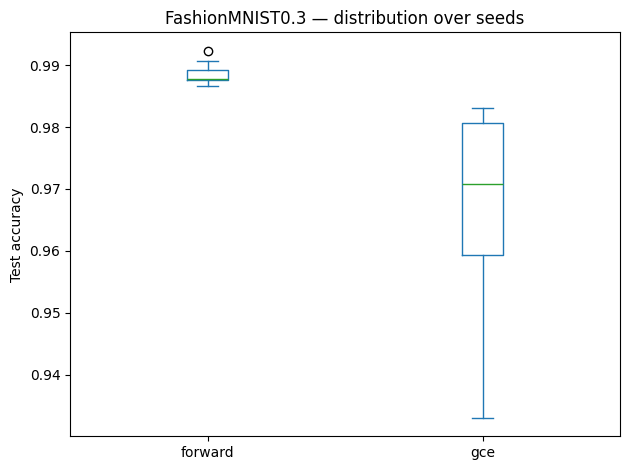

<Figure size 600x400 with 0 Axes>

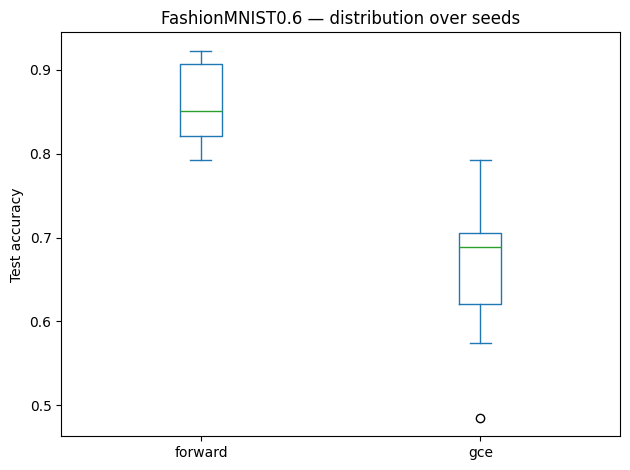

<Figure size 600x400 with 0 Axes>

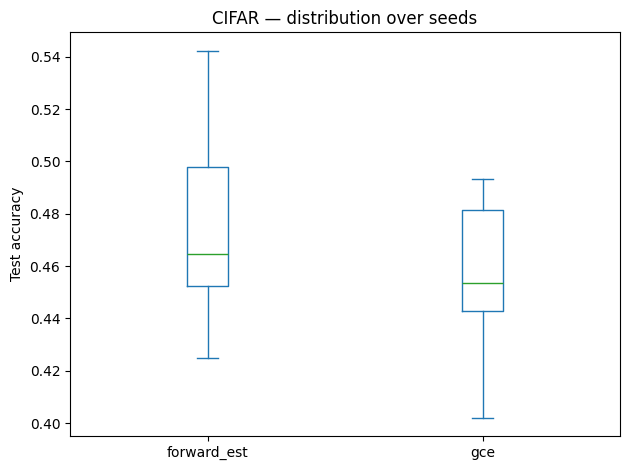

In [86]:
df_all = pd.concat([df, df_cf], ignore_index=True)

# 表格（放报告）
display(summarize_df(df_all))

# 逐数据集误差条
plot_errorbars_per_dataset(df_all)

# 逐数据集箱线图
plot_box_per_dataset(df_all)

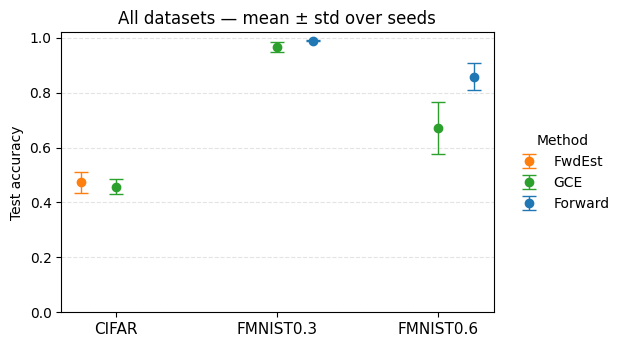

In [87]:
plot_errorbars_grouped_color(df_all)  